In [54]:
import pandas as pd
import os
import numpy as np
from notebooks.pareto_generator import generate_pareto
from notebooks.pareto_generator import filtra_fronteira_pareto_func

In [55]:
path_solutions = 'solutions/'

solution_df_list = []
resultados_agrupados_dict = dict()
X_var_dict = dict()
N_var_dict = dict()
for idx, sol in enumerate(os.listdir(path_solutions)):
    path_sol = path_solutions + sol + '/'
    
    sol_df = pd.read_csv(path_sol + 'solution.csv')
    sol_df['solution'] = idx
    solution_df_list.append(sol_df)

    X_var = pd.read_csv(path_sol + 'X_var.csv')
    X_var_dict[idx] = X_var

    N_var = pd.read_csv(path_sol + 'N_var.csv')
    N_var_dict[idx] = N_var

solution_df = pd.concat(solution_df_list).reset_index(drop=True)
solution_df.head(3)

,Fobj,Result,solution
0,Obj1,7.308386e+06,0
1,Obj2,5.323632e+01,0
2,Obj1,7.341257e+06,1


In [102]:
df_pivot = (
    solution_df
    .pivot(index='solution', columns='Fobj', values='Result')
    .rename(columns={'Obj1': 'obj1', 'Obj2': 'obj2'})
    .reset_index()
    .sort_values(by='obj1')
    # .drop(columns=['Fobj'])
)
# solutions_drop = pd.Series([24, 28, 13, 7, 6, 3, 16, 11, 2, 18])
df_pivot_new = df_pivot#df_pivot[~df_pivot['solution'].isin(solutions_drop)]

Hipervolume : 599878.9446665522
Delta_metric: 0.8316820113830178 


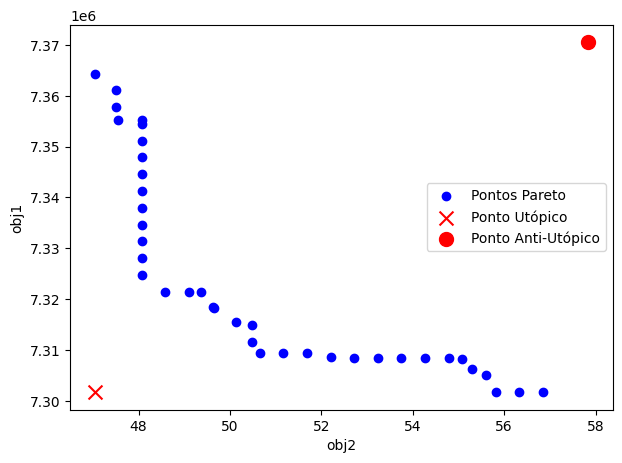

Hipervolume : 599878.9446665522
Delta_metric: 1.0865722105138285 


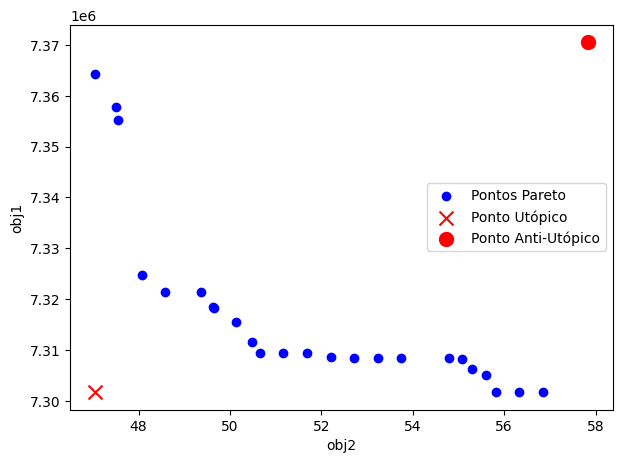

In [103]:
df_pivot = df_pivot_new
generate_pareto(df_pivot_new)
generate_pareto(df_pivot_new, filtra_pareto=True)

In [104]:
# decision_matrix = filtra_fronteira_pareto_func(df_pivot_new)
decision_matrix = df_pivot_new

In [105]:
agg_dict = {'Valor_Var': 'sum'}
decision_matrix['Pacientes por Hospital STDdev'] = (
    decision_matrix
    .apply(
        lambda x: X_var_dict[x['solution']]
        .groupby('Hospital')
        .agg(agg_dict)
        ['Valor_Var']
        .std()
    ,axis=1)
)

decision_matrix['Maximo Paciente em um dia no hospital'] = (
    decision_matrix
    .apply(
        lambda x: N_var_dict[x['solution']]
        .groupby(['Hospital', 'Dia'])
        .agg({'Valor_Var': 'sum'})
        .reset_index()
        .groupby('Hospital')
        .agg({'Valor_Var': 'max'})
        ['Valor_Var']
        .max()
        ,axis=1
    )
)
decision_matrix

Fobj,solution,obj1,obj2,Pacientes por Hospital STDdev,Maximo Paciente em um dia no hospital
12,12,7.301724e+06,56.850000,8272.440793,12803.333333
11,11,7.301859e+06,56.334248,8352.491473,12803.333333
4,4,7.301859e+06,55.817927,8444.003936,12803.333333
17,17,7.305018e+06,55.610000,8309.315490,12747.632142
28,28,7.306287e+06,55.301606,8404.807547,12755.500000
34,34,7.308313e+06,55.070000,8324.953614,12737.821256
30,30,7.308374e+06,54.785285,8380.309323,12760.000000
23,23,7.308374e+06,53.752643,8376.787631,12760.000000
2,2,7.308374e+06,54.268964,8329.557032,12760.000000
0,0,7.308386e+06,53.236322,8380.197274,12758.000000


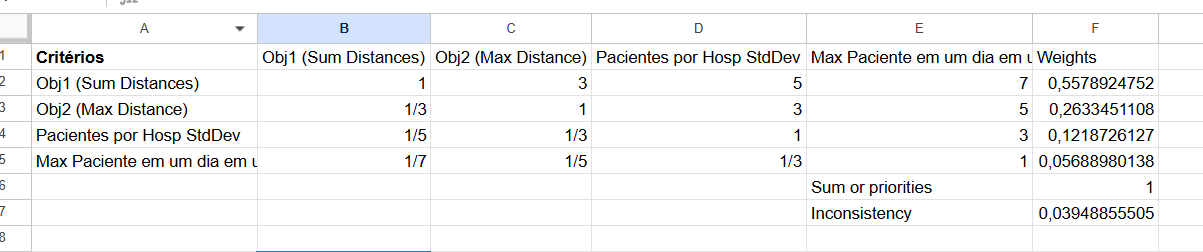

In [127]:
# Weights got from excel 
w_obj1 = 0.5578924752
w_obj2 = 0.2633451108
w_pacientes_por_hosp_stddev = 0.1218726127
w_max_pacientes_day = 0.05688980138

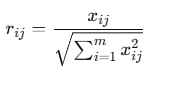

In [128]:
# Normalize matrix
obj1_factor = np.sqrt(np.sum([np.power(elem, 2) for elem in decision_matrix['obj1']]))
obj2_factor = np.sqrt(np.sum([np.power(elem, 2) for elem in decision_matrix['obj2']]))
pacientes_hosp_sttdev_factor = np.sqrt(np.sum([np.power(elem, 2) for elem in decision_matrix['Pacientes por Hospital STDdev']]))
max_paciente_factor = np.sqrt(np.sum([np.power(elem, 2) for elem in decision_matrix['Maximo Paciente em um dia no hospital']]))

normalized_matrix = decision_matrix.copy()
normalized_matrix['obj1'] = normalized_matrix['obj1'] / obj1_factor
normalized_matrix['obj2'] = normalized_matrix['obj2'] / obj2_factor
normalized_matrix['Pacientes por Hospital STDdev'] = normalized_matrix['Pacientes por Hospital STDdev'] / pacientes_hosp_sttdev_factor
normalized_matrix['Maximo Paciente em um dia no hospital'] = normalized_matrix['Maximo Paciente em um dia no hospital'] / max_paciente_factor
normalized_matrix.head(3)


Fobj,solution,obj1,obj2,Pacientes por Hospital STDdev,Maximo Paciente em um dia no hospital
12,12,0.161713,0.181692,0.162193,0.162941
11,11,0.161716,0.180044,0.163762,0.162941
4,4,0.161716,0.178394,0.165557,0.162941


In [129]:
# Apply weights
weighted_matrix = normalized_matrix.copy()
weighted_matrix['obj1'] = weighted_matrix['obj1'] * w_obj1
weighted_matrix['obj2'] = weighted_matrix['obj2'] * w_obj2
weighted_matrix['Pacientes por Hospital STDdev'] = weighted_matrix['Pacientes por Hospital STDdev'] * w_pacientes_por_hosp_stddev
weighted_matrix['Maximo Paciente em um dia no hospital'] = weighted_matrix['Maximo Paciente em um dia no hospital'] * w_max_pacientes_day
weighted_matrix.head(3)

Fobj,solution,obj1,obj2,Pacientes por Hospital STDdev,Maximo Paciente em um dia no hospital
12,12,0.090218,0.047848,0.019767,0.00927
11,11,0.090220,0.047414,0.019958,0.00927
4,4,0.090220,0.046979,0.020177,0.00927


In [130]:
# Store best and worst decisions
obj1_best_decision = weighted_matrix['obj1'].min()
obj2_best_decision = weighted_matrix['obj2'].min()
pacientes_hostp_stddev_best_decision = weighted_matrix['Pacientes por Hospital STDdev'].min()
max_paciente_best_decision = weighted_matrix['Maximo Paciente em um dia no hospital'].min()

obj1_worst_decision = weighted_matrix['obj1'].max()
obj2_worst_decision = weighted_matrix['obj2'].max()
pacientes_hostp_stddev_worst_decision = weighted_matrix['Pacientes por Hospital STDdev'].max()
max_paciente_worst_decision = weighted_matrix['Maximo Paciente em um dia no hospital'].max()

# Function to calculate distance of a given solution
def calculate_euclidian_distance_best_decision(obj1, obj2, pacientes_hosp_stddev, max_paciente):
    
    power_obj1 = np.power(obj1 - obj1_best_decision, 2)
    power_obj2 = np.power(obj2 - obj2_best_decision, 2)
    power_hosp_stddev = np.power(pacientes_hosp_stddev - pacientes_hostp_stddev_best_decision, 2)
    power_max_paciente = np.power(max_paciente - max_paciente_best_decision, 2)

    result = np.sqrt( 
        power_obj1 + 
        power_obj2 + 
        power_hosp_stddev + 
        power_max_paciente
    )
    return result

# Function to calculate distance of a given solution
def calculate_euclidian_distance_worst_decision(obj1, obj2, pacientes_hosp_stddev, max_paciente):
    
    power_obj1 = np.power(obj1 - obj1_worst_decision, 2)
    power_obj2 = np.power(obj2 - obj2_worst_decision, 2)
    power_hosp_stddev = np.power(pacientes_hosp_stddev - pacientes_hostp_stddev_worst_decision, 2)
    power_max_paciente = np.power(max_paciente - max_paciente_worst_decision, 2)

    result = np.sqrt( 
        power_obj1 + 
        power_obj2 + 
        power_hosp_stddev + 
        power_max_paciente
    )
    return result


# Calculate distance of each solution to best and worst decisions
weighted_matrix['S+'] = weighted_matrix.apply(
    lambda x: calculate_euclidian_distance_best_decision(
        obj1=x['obj1'], 
        obj2=x['obj2'],
        pacientes_hosp_stddev=x['Pacientes por Hospital STDdev'],
        max_paciente=x['Maximo Paciente em um dia no hospital']
    ), axis=1
)
weighted_matrix['S-'] = weighted_matrix.apply(
    lambda x: calculate_euclidian_distance_worst_decision(
        obj1=x['obj1'], 
        obj2=x['obj2'],
        pacientes_hosp_stddev=x['Pacientes por Hospital STDdev'],
        max_paciente=x['Maximo Paciente em um dia no hospital']
    ), axis=1
)

# Calculate P and define rank of decisions
weighted_matrix['P'] = weighted_matrix['S-'] / (weighted_matrix['S+'] + weighted_matrix['S-'])
weighted_matrix['Rank'] = weighted_matrix['P'].rank(ascending=False)
weighted_matrix

Fobj,solution,obj1,obj2,Pacientes por Hospital STDdev,Maximo Paciente em um dia no hospital,S+,S-,P,Rank
12,12,0.090218,0.047848,0.019767,0.009270,0.008298,0.000929,0.100667,38.0
11,11,0.090220,0.047414,0.019958,0.009270,0.007888,0.000942,0.106706,37.0
4,4,0.090220,0.046979,0.020177,0.009270,0.007490,0.001166,0.134718,36.0
17,17,0.090259,0.046804,0.019855,0.009229,0.007270,0.001345,0.156130,35.0
28,28,0.090275,0.046545,0.020083,0.009235,0.007046,0.001501,0.175597,34.0
34,34,0.090300,0.046350,0.019892,0.009222,0.006825,0.001696,0.199052,33.0
30,30,0.090301,0.046110,0.020025,0.009238,0.006608,0.001888,0.222212,32.0
23,23,0.090301,0.045241,0.020016,0.009238,0.005751,0.002710,0.320311,30.0
2,2,0.090301,0.045675,0.019903,0.009238,0.006160,0.002311,0.272817,31.0
0,0,0.090301,0.044806,0.020024,0.009237,0.005326,0.003130,0.370126,29.0


In [131]:
# Chosen decision
filter_decision = weighted_matrix['Rank'] == 1
best_decision = weighted_matrix[filter_decision].index[0]


pareto_best_decision = (
    decision_matrix[filter_decision]['obj1'].iloc[0], 
    decision_matrix[filter_decision]['obj2'].iloc[0], 
)
decision_matrix[filter_decision]


Fobj,solution,obj1,obj2,Pacientes por Hospital STDdev,Maximo Paciente em um dia no hospital
6,6,7.357730e+06,47.51,7973.039279,12697.666667


Hipervolume : 599878.9446665522
Delta_metric: 0.8316820113830178 


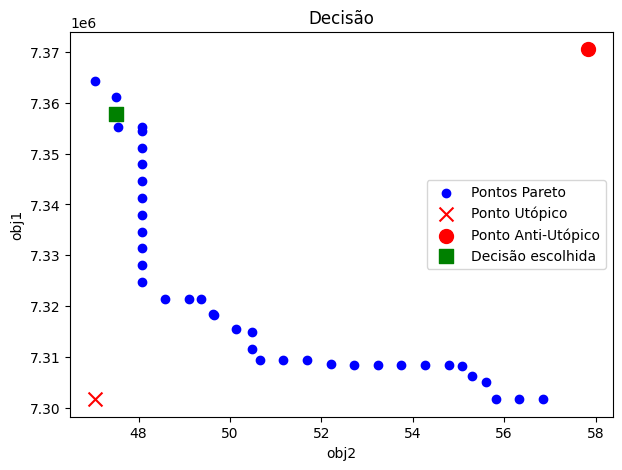

In [132]:
generate_pareto(decision_matrix, title='Decisão', decision=pareto_best_decision)